In [1]:
# # 그래픽 카드 둘로 쓰기 (두개 있을때, 하나만 있다면 0)
# # gpu idx 를 0 또는 1 로 설정하시오
# import tensorflow as tf 
# import os

# os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # gpu idx

# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

In [2]:
from tensorflow.python.client import device_lib 
import tensorflow as tf 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        print("Got error idoit")
print(gpus)

ah = device_lib.list_local_devices()
print([x.name for x in ah])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']


In [3]:
# 경로에 폴더가 없으면 폴더 만들기
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [4]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
import itertools
import pathlib
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

EPOCH = 100
KERNEL_SIZE = 3
BATCH_SIZE = 128
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

DATA_PATH = "./spectrogram_plt/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

# 데이터 불러오기

In [5]:
data_dir = pathlib.Path(DATA_PATH)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

f = list(data_dir.glob('F/*'))
n = list(data_dir.glob('N/*'))
q = list(data_dir.glob('Q/*'))
s = list(data_dir.glob('S/*'))
v = list(data_dir.glob('V/*'))

spectrogram_plt
112599


# 데이터 split
## train, test, validation data 나누기

In [6]:
parents_path = DATA_PATH

In [7]:
parents_path = DATA_PATH
child_path = os.listdir(parents_path)

npy_check_list = []

temp_converted_img = list()
temp_ann_list = list()
X = list()
y = list()

for pic_path in (child_path):
    current_path = os.listdir(parents_path + pic_path)
    print("[INFO] Current path : " + parents_path + pic_path)
    for file_name in tqdm(current_path):
        path_for_array = parents_path + pic_path + "/" + file_name

        img = cv2.imread(path_for_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        temp_converted_img.append(img_resize / 255.0)
        
        check_ann = pic_path
        
        if check_ann == "N":            # Normal
            temp_ann_list.append([1, 0, 0, 0, 0])
        
        elif check_ann == "S":          # Supra-ventricular
            temp_ann_list.append([0, 1, 0, 0, 0])
        
        elif check_ann == "V":          # Ventricular
            temp_ann_list.append([0, 0, 1, 0, 0])
        
        elif check_ann == "F":          # False alarm
            temp_ann_list.append([0, 0, 0, 1, 0])
        
        else:                           # Unclassed 
            temp_ann_list.append([0, 0, 0, 0, 1])
    
        y.append(temp_ann_list)

[INFO] Current path : ./spectrogram_plt/F


100%|██████████| 803/803 [00:00<00:00, 969.54it/s]


[INFO] Current path : ./spectrogram_plt/N


100%|██████████| 90631/90631 [01:41<00:00, 892.65it/s]


[INFO] Current path : ./spectrogram_plt/Q


100%|██████████| 11148/11148 [00:12<00:00, 874.75it/s]


[INFO] Current path : ./spectrogram_plt/S


100%|██████████| 2781/2781 [00:03<00:00, 875.07it/s]


[INFO] Current path : ./spectrogram_plt/V


100%|██████████| 7236/7236 [00:08<00:00, 849.60it/s]


In [8]:
onehot_y = np.array(temp_ann_list)
temp_converted_img = np.array(temp_converted_img)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(temp_converted_img, onehot_y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

print("[SIZE]\t\tNpX lenght : {}\n\t\tNpY length : {}".format(X_train.shape, y_train.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(X_val.shape, y_val.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(X_test.shape, y_test.shape))

[SIZE]		NpX lenght : (75441, 64, 64, 3)
		NpY length : (75441, 5)
[SIZE]		X_validation length : (12263, 64, 64, 3)
		y_validation length : (12263, 5)
[SIZE]		X_test length : (24895, 64, 64, 3)
		y_test length : (24895, 5)


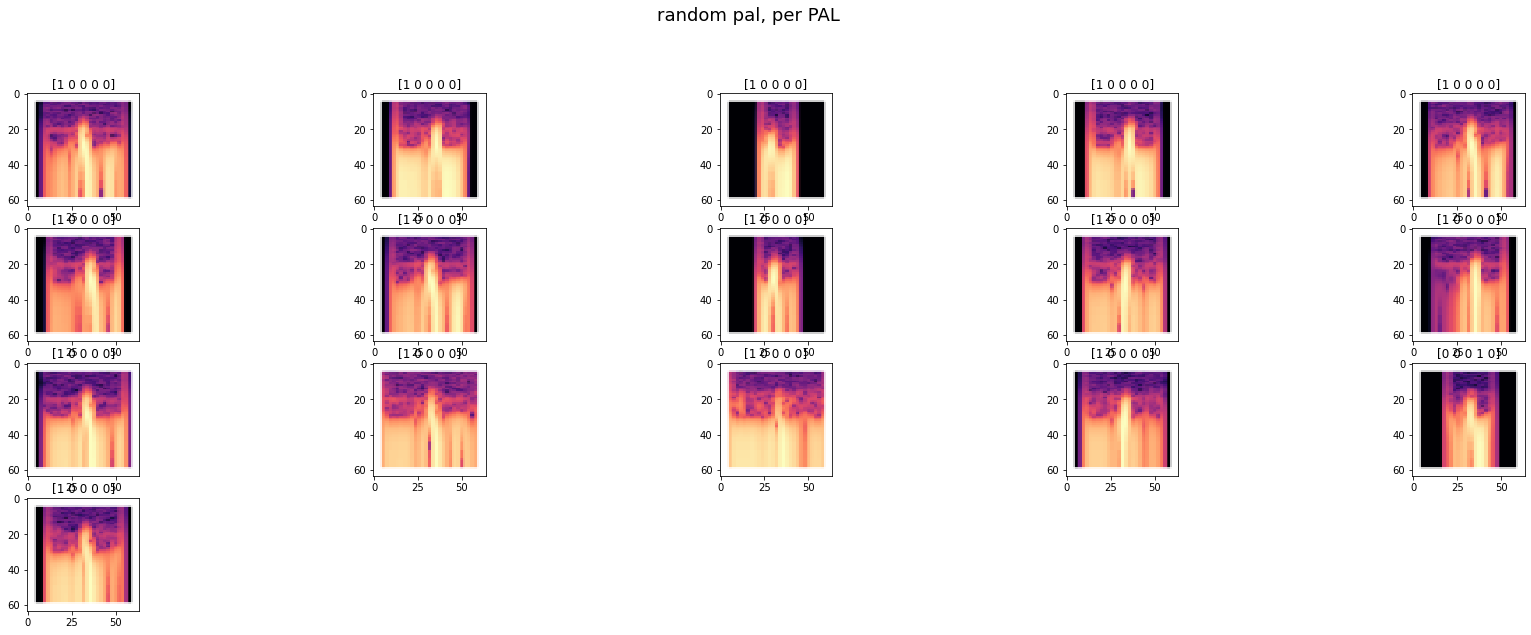

In [10]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
random.seed(11)
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(temp_converted_img[i], interpolation='nearest')
    ax.set_title(str(onehot_y[i]))
    n+=1

# 모델 생성

In [11]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [12]:
input_size = (64, 64, 3)

# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

def inception(x, filters_1, filters_1to3, filters_3, filters_1to5, filters_5, filters_pool_proj, kernel_init=kernel_init, bias_init=bias_init):
    conv_1      = layers.Conv2D(filters_1,      (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_1to3   = layers.Conv2D(filters_1to3,   (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3      = layers.Conv2D(filters_3,      (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_1to3)
    
    conv_1to5   = layers.Conv2D(filters_1to5,   (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5      = layers.Conv2D(filters_5,      (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_1to5)
    
    max_pool    = layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool_proj   = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(max_pool)
    output      = layers.concatenate([conv_1, conv_3, conv_5, pool_proj])
    return output

input_layer = layers.Input(shape=input_size)

x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = layers.MaxPool2D(   pool_size=(3, 3), strides=2, padding='same')(x)
x = layers.Conv2D(64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = layers.Conv2D(192,kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = layers.MaxPool2D(   pool_size=(3, 3), strides=2, padding='same')(x)

x = inception(x, 64, 96, 128, 16, 32, 32)
x = inception(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

x = inception(x, 192, 96, 208, 16, 48, 64)

x1 = layers.AveragePooling2D(pool_size=(3, 3), strides=3)(x)
x1 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1) #0.7
x1 = layers.Dense(5, activation='softmax', name='aux_1')(x1)

x = inception(x, 160, 112, 224, 24, 64, 64)
x = inception(x, 128, 128, 256, 24, 64, 64)
x = inception(x, 112, 144, 288, 32, 64, 64)

x2 = layers.AveragePooling2D(pool_size=(3, 3), strides=3)(x)
x2 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2) #0.7
x2 = layers.Dense(5, activation='softmax', name='aux_2')(x2)

x = inception(x, 256, 160, 320, 32, 128, 128)
x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

x = inception(x, 256, 160, 320, 32, 128, 128)
x = inception(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) #0.4
x = layers.Dense(5, activation='softmax', name='final')(x)

googleNet = keras.Model(input_layer, [x, x1, x2])

In [13]:
googleNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   4160        ['max_pooling2d[0][0]']          
                                                                                              

In [14]:
googleNet.compile(
        optimizer='adam',
        # loss="sparse_categorical_crossentropy",
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

### 콜백 설정

In [15]:
# 콜백 설정
from keras.callbacks import EarlyStopping, ModelCheckpoint

outDir = './cheakpoint/googleNet_spectrogram/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{final_accuracy:.4f}.h5'

def get_callbacks(patience = 50): 
    # with tf.device('/device:GPU:0'):
        earlystop = EarlyStopping(monitor='final_accuracy', min_delta=0.0001, patience=patience)
        model_checkpoint = ModelCheckpoint(model_names, monitor='final_accuracy', verbose=1, save_best_only=True, period = 1)

        # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
        callbacks = [model_checkpoint]
        return callbacks

# 학습하기

In [16]:
callbacks = get_callbacks()

models_hist = googleNet.fit( 
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks = [callbacks]
)

Epoch 1/100
590/590 [==============================] - ETA: 0s - loss: 1.3867 - final_loss: 0.4772 - aux_1_loss: 0.4480 - aux_2_loss: 0.4616 - final_accuracy: 0.8660 - aux_1_accuracy: 0.8695 - aux_2_accuracy: 0.8676
Epoch 1: final_accuracy improved from -inf to 0.86599, saving model to ./cheakpoint/googleNet_spectrogram\weights-0.8660.h5
590/590 [==============================] - 56s 74ms/step - loss: 1.3867 - final_loss: 0.4772 - aux_1_loss: 0.4480 - aux_2_loss: 0.4616 - final_accuracy: 0.8660 - aux_1_accuracy: 0.8695 - aux_2_accuracy: 0.8676 - val_loss: 0.5791 - val_final_loss: 0.2056 - val_aux_1_loss: 0.1818 - val_aux_2_loss: 0.1917 - val_final_accuracy: 0.9347 - val_aux_1_accuracy: 0.9438 - val_aux_2_accuracy: 0.9406
Epoch 2/100
589/590 [============================>.] - ETA: 0s - loss: 0.4119 - final_loss: 0.1423 - aux_1_loss: 0.1314 - aux_2_loss: 0.1381 - final_accuracy: 0.9582 - aux_1_accuracy: 0.9604 - aux_2_accuracy: 0.9587
Epoch 2: final_accuracy improved from 0.86599 to 0.95

# 결과 시각화 하기

In [17]:
# 학습 된 모델의 학습 과정 시각화
import matplotlib.pyplot as plt
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['final_accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_final_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

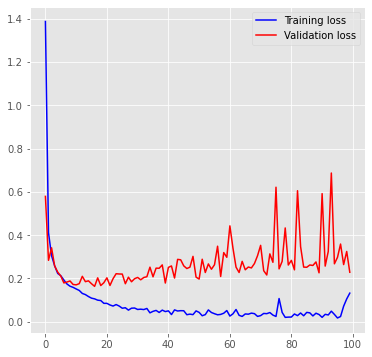

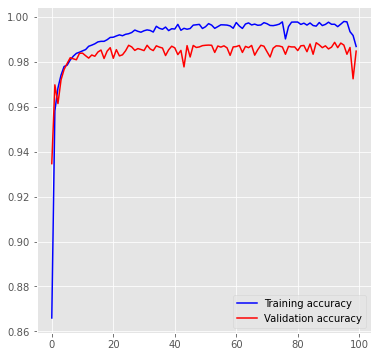

384/384 [==============================] - 10s 24ms/step - loss: 0.2288 - final_loss: 0.0907 - aux_1_loss: 0.0665 - aux_2_loss: 0.0716 - final_accuracy: 0.9848 - aux_1_accuracy: 0.9856 - aux_2_accuracy: 0.9852
[0.22877807915210724, 0.09071553498506546, 0.06646649539470673, 0.07159609347581863, 0.9847508668899536, 0.9856478571891785, 0.9851586222648621]


In [18]:
plot_model__hist(models_hist)
loss = googleNet.evaluate(X_val, y_val)
# print("multi_model의 정확도: {:5.2f}%".format(100*loss))
print(loss)

# 모델 불러와서 confusion matrix 그리기

In [19]:
tf.keras.backend.clear_session()

In [21]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/googleNet_spectrogram/weights-0.9980.h5")

In [30]:
# 예측값 얻기
with tf.device('/device:CPU:0'):
    y_pred = reconstructed_model.predict(X_test)
y_pred = y_pred[-1]

778/778 [==============================] - 45s 58ms/step


In [31]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [32]:
# np.array(y_pred).shape
print(len(y_pred))

24895


In [34]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

In [35]:
np.array(new_y_pred).shape

(24895,)

In [36]:
# 최종 정확도 산출
score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

778/778 [==============================] - 19s 23ms/step - loss: 0.3266 - final_loss: 0.1089 - aux_1_loss: 0.1083 - aux_2_loss: 0.1094 - final_accuracy: 0.9863 - aux_1_accuracy: 0.9865 - aux_2_accuracy: 0.9867
정답률 =  0.10894905775785446 loss= 0.32661592960357666


### confusion matrix 그리기

In [37]:
print(np.array(new_y_pred).shape)

(24895,)


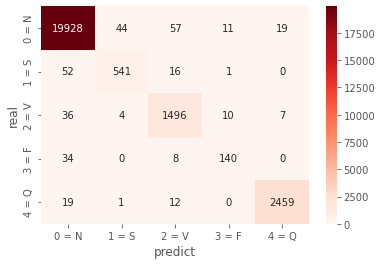

In [38]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

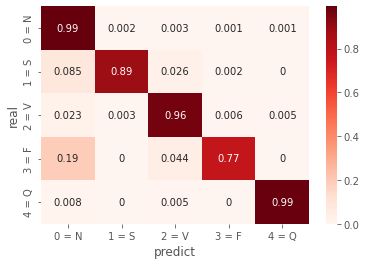

In [39]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

array([[19928,    44,    57,    11,    19],
       [   52,   541,    16,     1,     0],
       [   36,     4,  1496,    10,     7],
       [   34,     0,     8,   140,     0],
       [   19,     1,    12,     0,  2459]], dtype=int64)

In [41]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       0 = N       0.99      0.99      0.99     20059
       1 = S       0.92      0.89      0.90       610
       2 = V       0.94      0.96      0.95      1553
       3 = F       0.86      0.77      0.81       182
       4 = Q       0.99      0.99      0.99      2491

    accuracy                           0.99     24895
   macro avg       0.94      0.92      0.93     24895
weighted avg       0.99      0.99      0.99     24895

